## Introduction


### Time Series with External Regressors

This is a note on working with time series *with* external regressors, *and* specifying if the external regressors are treated as transient (short impulse response) or durable (long term impulse response).

The generative system we are interested in is the following with `y_auto` unobserved and `y` observed.

```
  y_auto[i] ~ b_auto_0 + b_auto . (y_auto[i-l1], ..., y_auto[i-lk]) + b_z . z[i]
  y[i] ~ y_auto[i] + b_x . x[i]
```

Where l1, ..., lk are our lags, z[] are durable external regressors, and x[] are transient external regressors.

We will call external regressors that do not contribute to future time indices (as above) "transient". Our data will be so generated, and we will see models that are structured to expect this structure outperform models that are not so structured. We will call any external regressors in the `y_auto` series "durable" as they (indirectly) affect future measurements. We will call a model that matches the structure of the assumed data generating process as "structure respecting", and one that does not as "disrespecting." Having a good guess of the model structure is a positive and useful inductive bias.

The above distinction is dealing with durable AR (or auto-regressive, or infinite impulse response) issues in external regressors (in addition to AR issues in observations), and transient MA (or "moving average", though the term merely means finite impulse response in time series work- not an actual "moving average").

On terminology: from Box, Jenkins, Reinsel, *Time Series Analysis: Forecasting and Control*, 4th Edition, Wiley, 2008 (Introduction p. 10) we have the following.

> The name "moving average" is somewhat misleading because the weights 1, -&theta;<sub>1</sub>, -&theta;<sub>2</sub>, ... -&theta;<sub>q</sub>, which multiply the a's need not total to unity nor need they be positive. However, this nomenclature is in common use, and therefore we employ it.

## Setting up our example

In [1]:
# set up Python
import logging
import numpy as np
import pandas as pd
from plotnine import *

from nested_model_fns import (
    build_example, 
    train_test_split, 
    define_Stan_model_with_forecast_period, 
    solve_forecast_by_Stan,
    plot_forecast,
    extract_sframe_result,
    plot_model_quality,
    plot_model_quality_by_prefix,
    plot_recent_state_distribution,
    apply_linear_model_bundle_method,
)

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(2024)


Our example data is as follows.

In [3]:
# specify example
generating_lags = (1, 2)
gen_scale = 5.2
gen_shift = 10.0
b_auto = (2 * np.cos(np.pi/20), -1)  # angle addition
b_auto_0 = gen_scale * gen_shift * (1 - np.sum(b_auto))
# external regressors
b_z = (4.2, )
b_x = (16.1, )

generating_params = {
    'b_auto_0': b_auto_0,
    'b_auto': b_auto,
    'b_z': b_z,
    'b_x': b_x,
}

# show original generative parameters
generating_params


{'b_auto_0': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_z': (4.2,),
 'b_x': (16.1,)}

In [4]:
# build the example
d_example = build_example(
    rng=rng,
    generating_lags=generating_lags,
    b_auto=b_auto,
    b_auto_0=b_auto_0,
    b_z=b_z,
    b_x=b_x,
)

d_example['ext_regressors'] = [
    f'z_0: {z_0}, x_0: {x_0}' 
    for z_0, x_0 in zip(d_example['z_0'], d_example['x_0'])]

In [5]:
# split into test and train by time
d_train, d_test = train_test_split(d_example)
d_train.to_csv("d_train.csv", index=False)
d_test.to_csv("d_test.csv", index=False)


In [6]:
# show training data
d_train


,time_tick,z_0,x_0,y,ext_regressors
0,0,0,0,52.987245,"z_0: 0, x_0: 0"
1,1,0,1,70.018009,"z_0: 0, x_0: 1"
2,2,0,0,55.200982,"z_0: 0, x_0: 0"
3,3,0,0,56.176554,"z_0: 0, x_0: 0"
4,4,1,0,60.765894,"z_0: 1, x_0: 0"
...,...,...,...,...,...
945,945,0,1,96.520180,"z_0: 0, x_0: 1"
946,946,0,0,74.460774,"z_0: 0, x_0: 0"
947,947,0,1,83.881812,"z_0: 0, x_0: 1"
948,948,0,0,61.710579,"z_0: 0, x_0: 0"


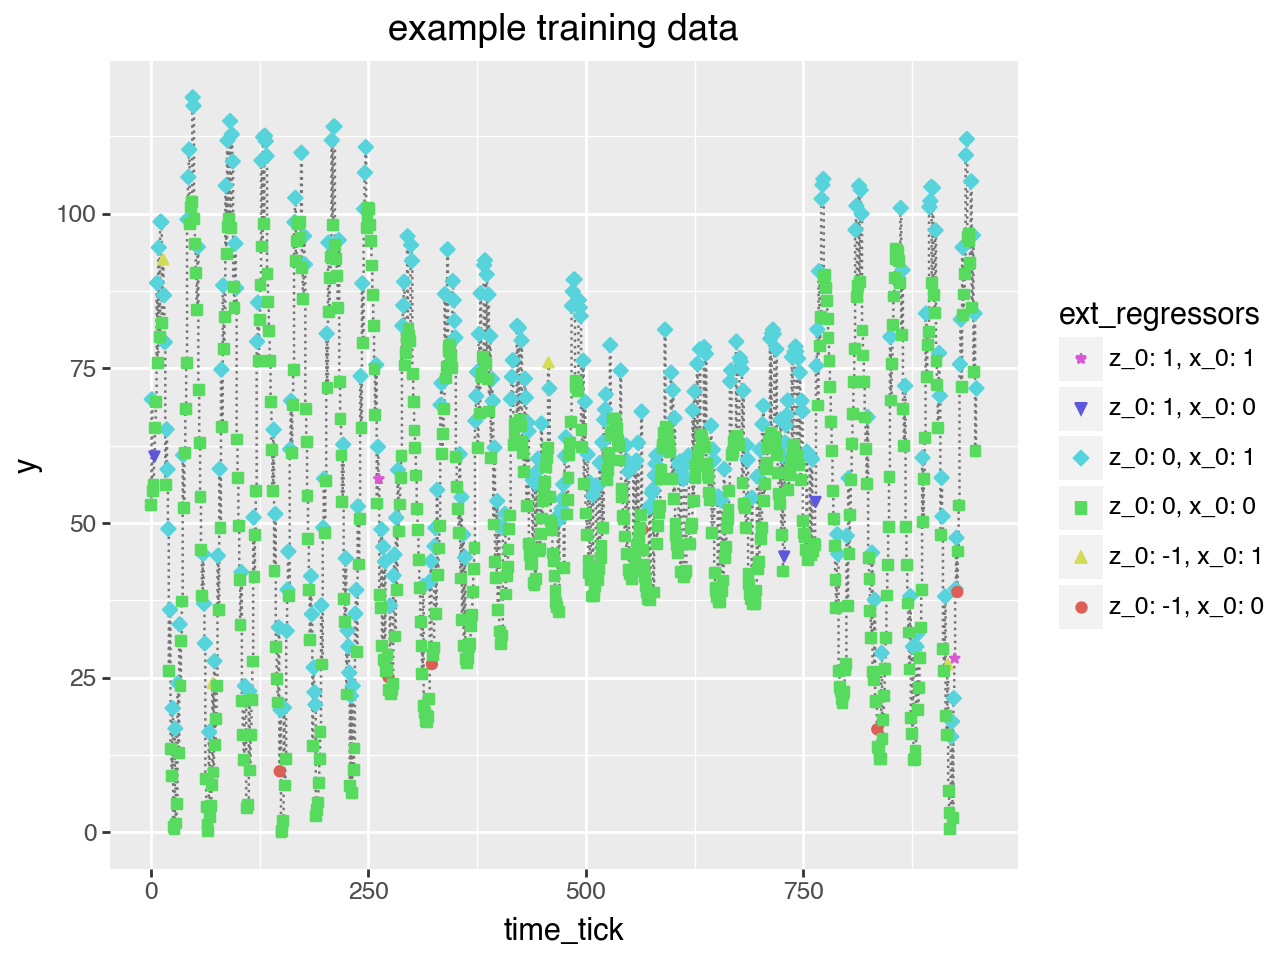

In [7]:
# plot training data
(
    ggplot(
        data=d_train,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data")
)


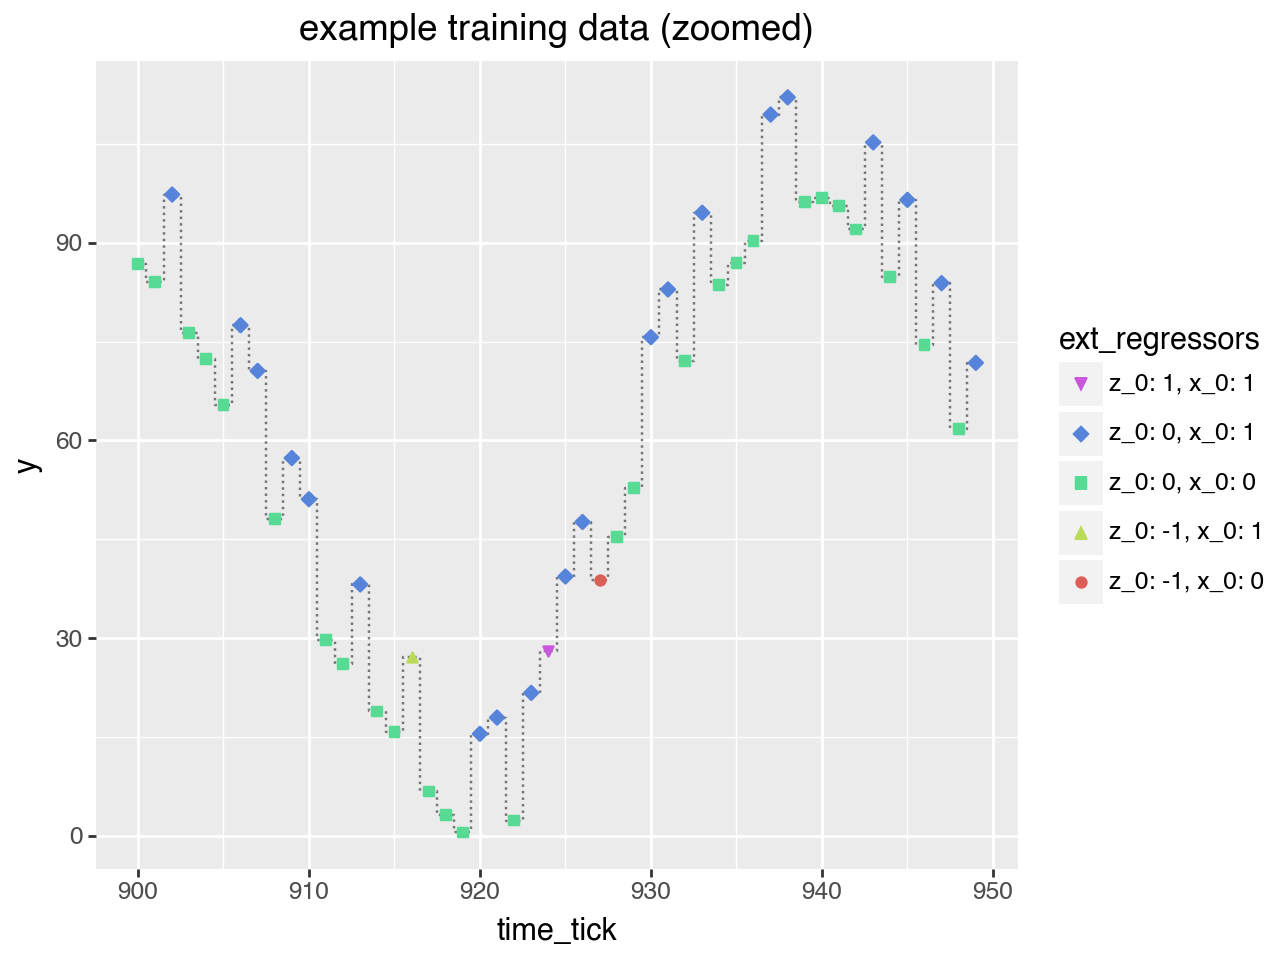

In [8]:
# zoom in on training data and annotate
d_train_zoomed = d_train.loc[
    d_train['time_tick'] >= (d_train.shape[0] - d_test.shape[0]), 
    :].reset_index(drop=True, inplace=False)
(
    ggplot(
        data=d_train_zoomed,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data (zoomed)")
)


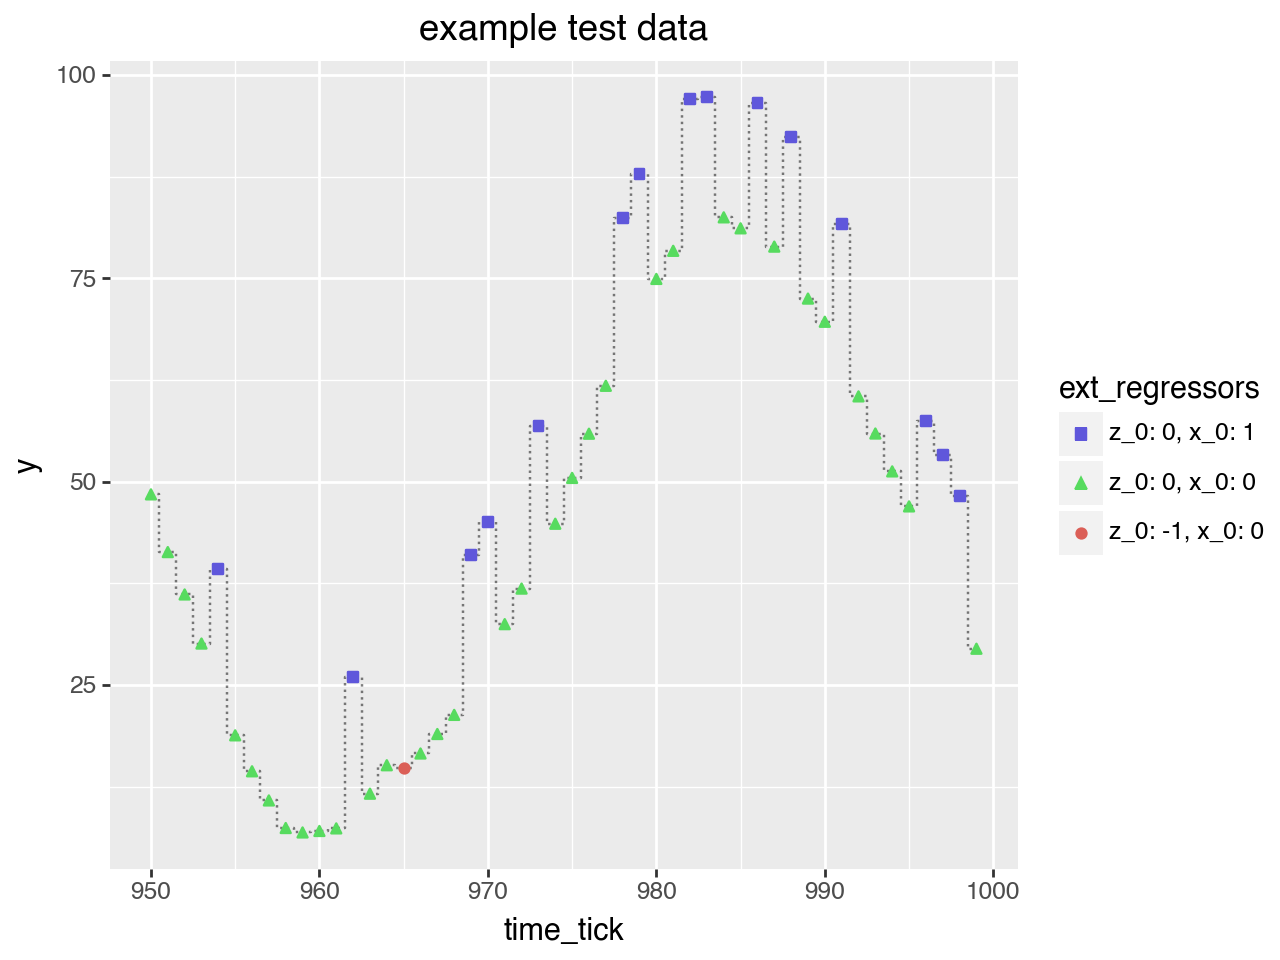

In [9]:
# plot test data
(
    ggplot(
        data=d_test,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example test data")
)


## Ignoring External Regressors

Now, let's demonstrate attempting to fit a direct linear model bundle, without external regressors. In this a linear model bundle is a bundle of models which for each <code>k &ge; 0</code>, we predict <code>y[i + k] ~ g(x[i + k]) + f(y[i-l1], y[i-l2], ..., y[i-lk])</code>. The <code>li</code> are positive date/time index lags, and <code>g()</code>, and <code>f()</code> are linear functions to be fit. This formulation is simple, but not quite structure respecting- as the external regressors are modeled as having a durable effect.

In the first case we have no external regressors, so this is <code>y[i + k] ~ f(y[i-l1], y[i-l2], ..., y[i-lk])</code>.


In [10]:
d_test['linear model bundle (no external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    d_train=d_train,
    d_apply=d_test,
)


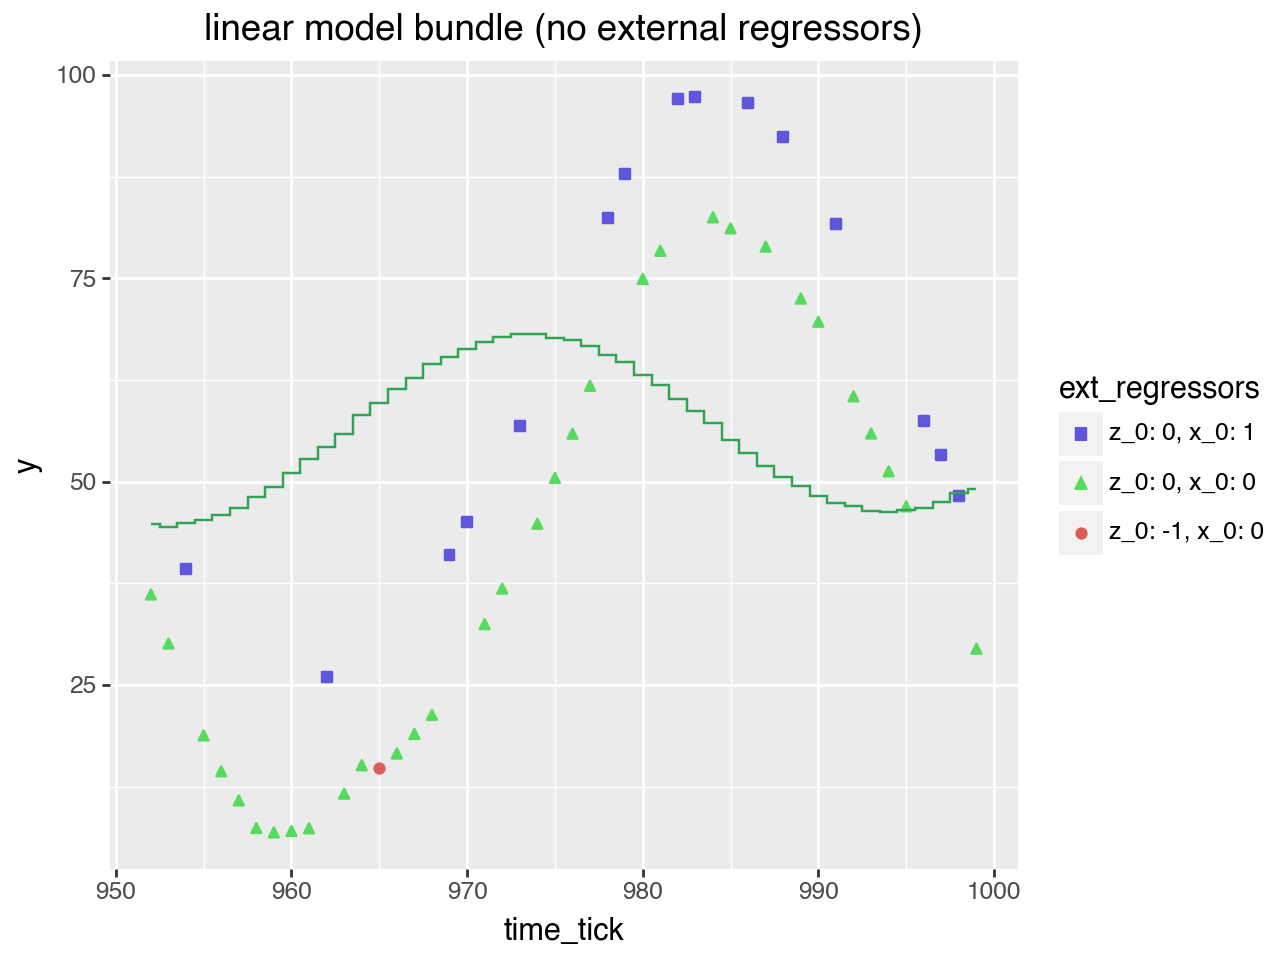

In [11]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (no external regressors)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (no external regressors)")
)


As the model has no access the external regressors, it can't take advantage of them and is forced to pick a "mid-path" through previous training data. This path then deviates a lot in out of sample test data, as the un-modeled effect of the external regressors also obscures important forward relations.

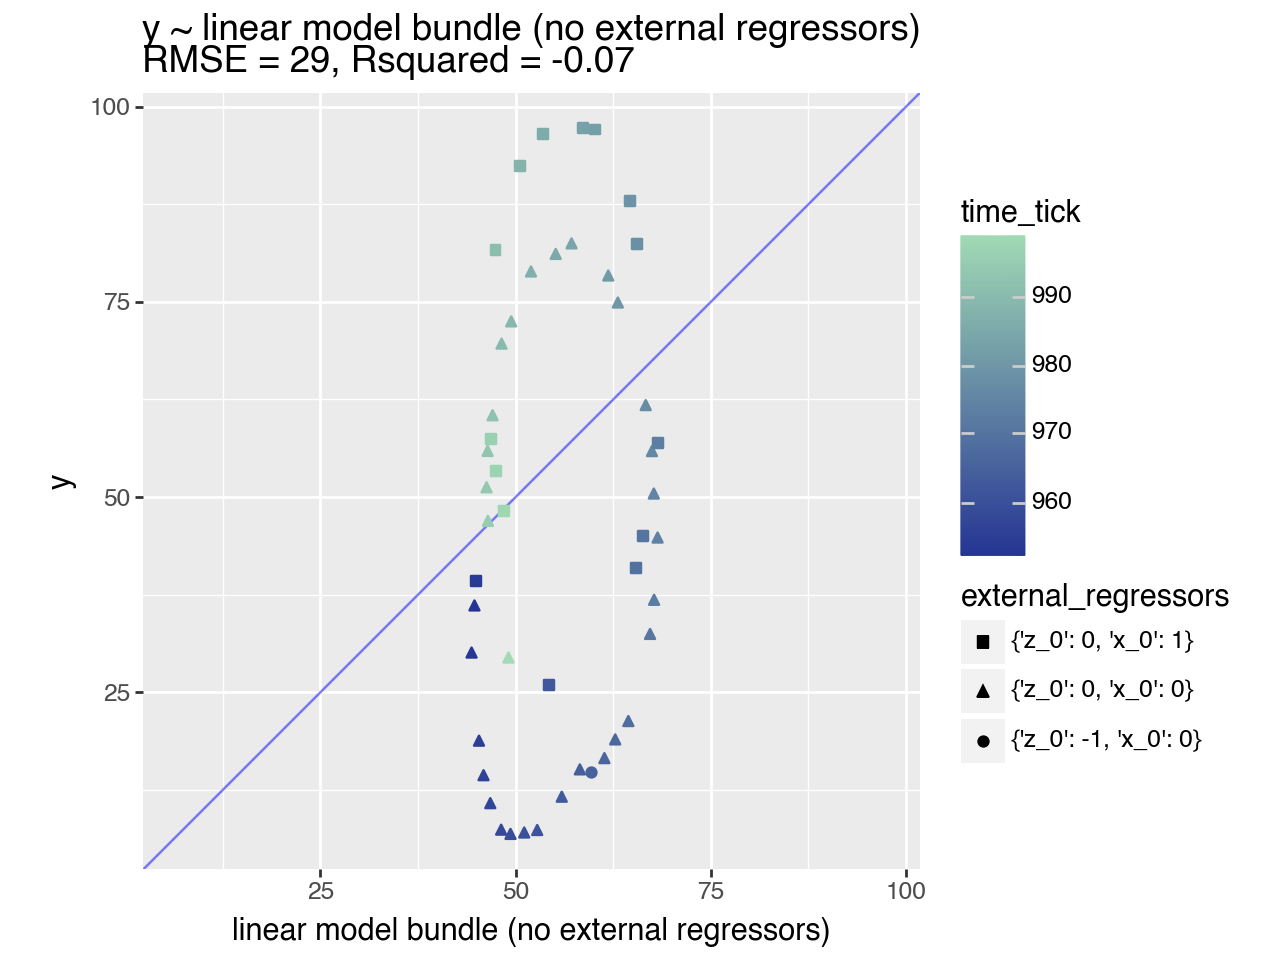

In [12]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (no external regressors)']) == False, :],
    result_name='linear model bundle (no external regressors)',
    external_regressors=['z_0', 'x_0'],
)


## Adding in external regressors simplest try (not respecting problem domain structure)

Another thing to try is a linear model bundle with jointly estimated (or, unfortunately, non-structure respecting durable) external regressor effects. We show that here.


In [13]:
d_test['linear model bundle (durable external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    durable_external_regressors=['z_0', 'x_0'],
    d_train=d_train,
    d_apply=d_test,
)


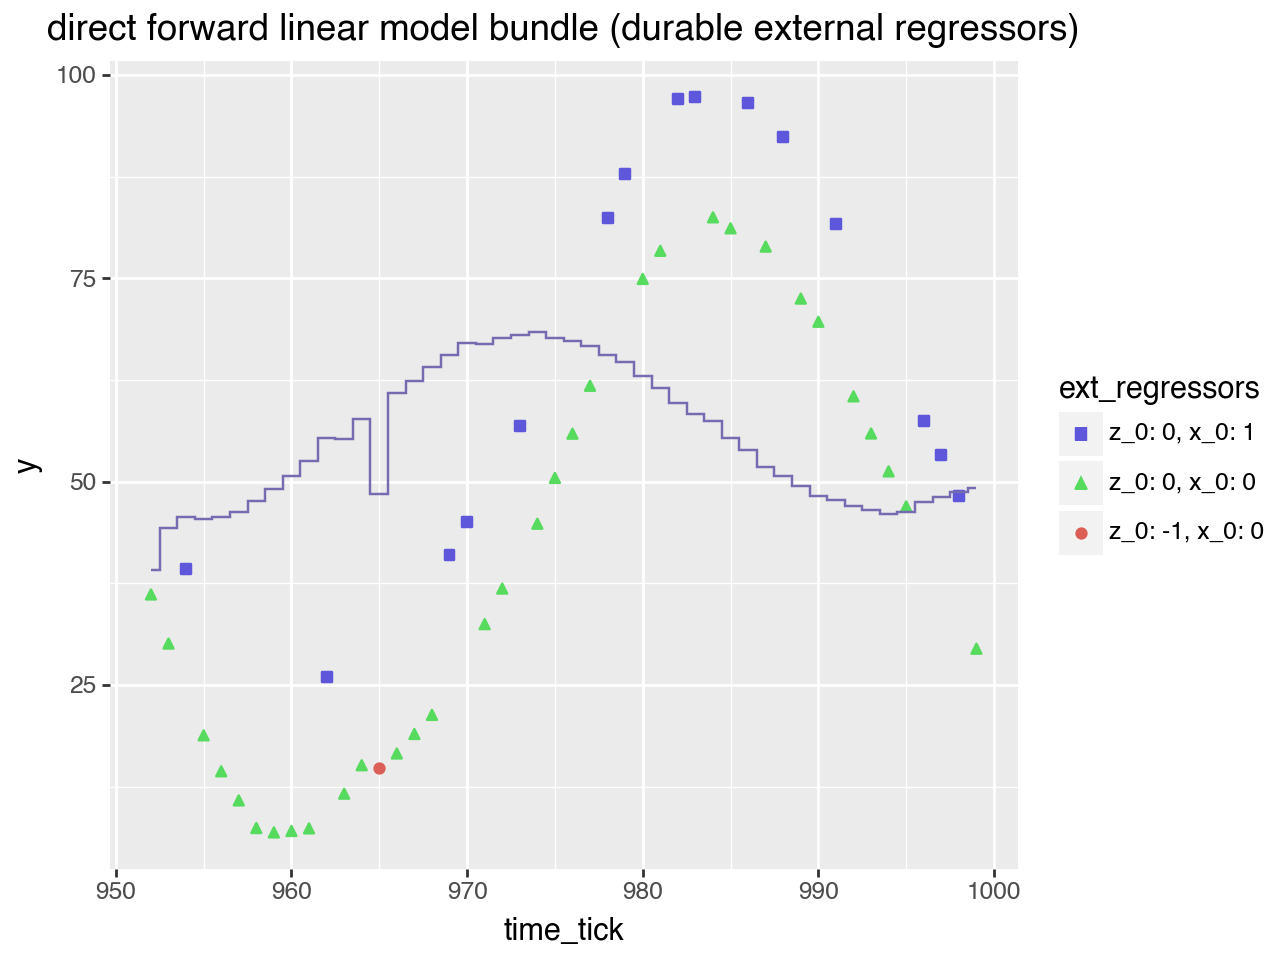

In [14]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (durable external regressors)'), 
        color='#756bb1',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("direct forward linear model bundle (durable external regressors)")
)


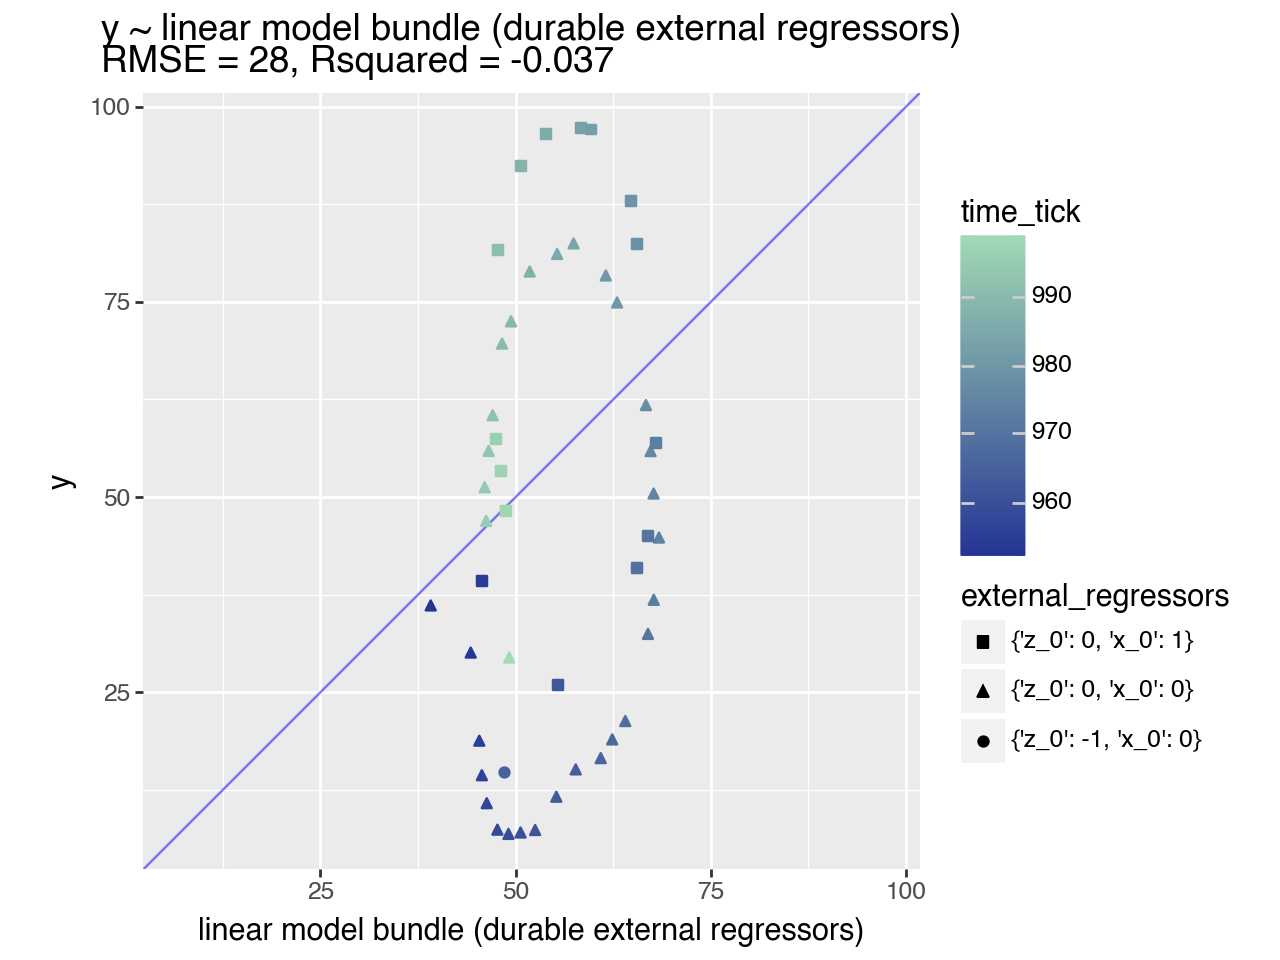

In [15]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (durable external regressors)']) == False, :],
    result_name='linear model bundle (durable external regressors)',
    external_regressors=['z_0', 'x_0'],
)


This model has *slightly() better quality, but is not picking up all of the signal.

## Adding external regressors compatible with stated problem structure

Now we try a linear model with a subtracted (pulled-off) pre-estimate of external regressors. This is an attempt to respect the expected transient nature of the external regressors. The estimation method is a bit ad-hoc (being an iterative fraction of variables active estimate), but turns out to be quite powerful.


In [16]:
d_test['linear model bundle (correct external regressor structure)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    durable_external_regressors=['z_0'],
    transient_external_regressors=['x_0'],
    d_train=d_train,
    d_apply=d_test,
)


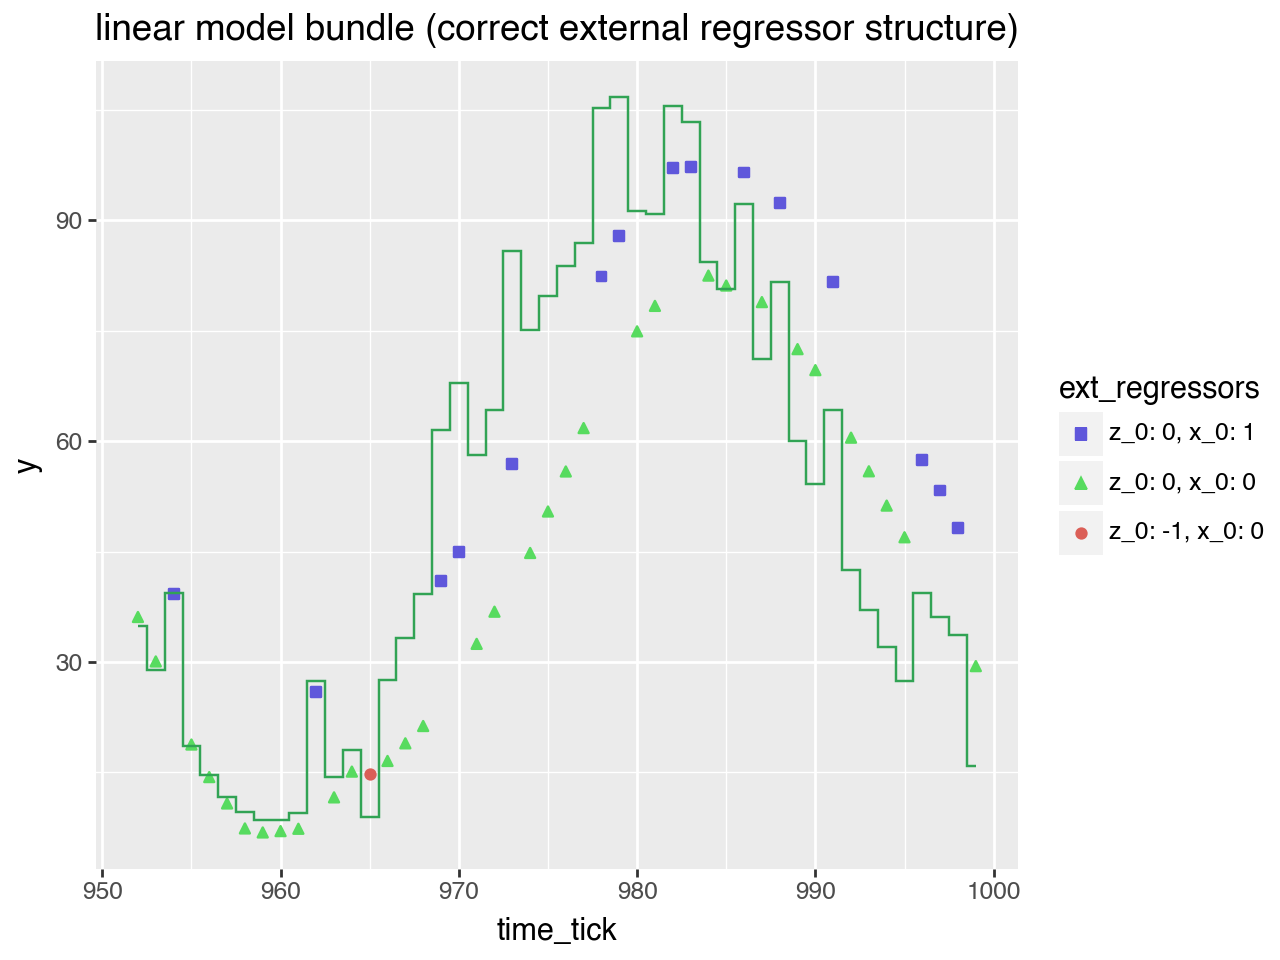

In [17]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (correct external regressor structure)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (correct external regressor structure)")
)


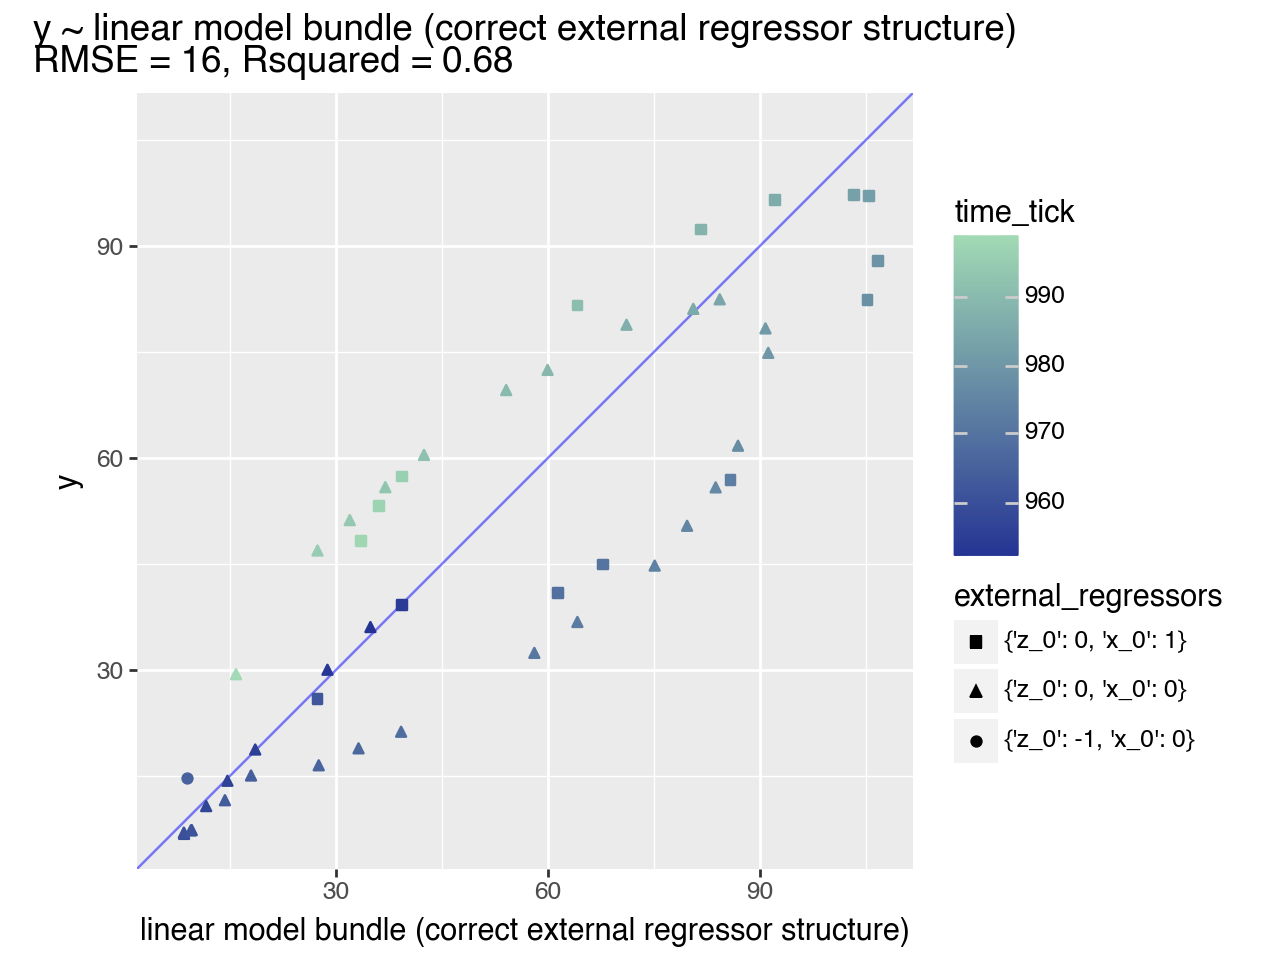

In [18]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (correct external regressor structure)']) == False, :],
    result_name='linear model bundle (correct external regressor structure)',
    external_regressors=['z_0', 'x_0'],
)


When the external contributions are already in `y` or "outcome" units, the above can be done properly with an ARX model of section 2.2.1.2 pp.21-22 of Gianluigi Pillonetto , Tianshi Chen , Alessandro Chiuso , Giuseppe De Nicolao , Lennart Ljung *Regularized System Identification*, Springer 2022 (open access link: https://link.springer.com/book/10.1007/978-3-030-95860-2 ). This is *almost* a linear regression with additional equality constraints (to match the lag structure of the external regressors and observed outcomes). When one has to infer the conversion factors from external regressors to outcomes, one has a model with some product terms of inferred quantities (so not a linear model).

## Solving again with the Bayesian "big hammer"

We now try a Bayesian model with the correct generative structure, using the [Stan](https://mc-stan.org/users/interfaces/cmdstan) software package.



In [19]:
# define a Stan model for both transient external regressors and future predictions
stan_model_with_forecast_i, stan_model_with_forecast_src_i = define_Stan_model_with_forecast_period(
    application_lags=generating_lags,
    n_transient_external_regressors=len(b_x),
    n_durable_external_regressors=len(b_z),
)


In [20]:
# show the model specification
print(stan_model_with_forecast_src_i)



data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;            // observed outcomes
  vector[N_y_observed + N_y_future] x_imp_1;  // observed transient external regressor
  vector[N_y_observed + N_y_future] x_dur_1;  // observed durable external regressor
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[1] b_x_imp;                          // transient external regressor coefficients
  vector[1] b_x_dur;                          // durable external regressor coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (dura

`y` and `y_auto` are supposed to be non-negative (a constraint we have chosen to *not* enforce, as it degraded results, probably by damaging sampling paths).

Please keep in mind a distributional statement such as <code>y ~ normal(f(y_auto, x), &sigma;)</code> is actually modeling the residual <code>(y - f(y_auto, x))</code> as being distributed <code>normal(0, &sigma;)</code>. So the above model-block statements are distributional assumptions about *residuals*, as the intended mean is an input to these statements. Thus we are specifying a normal distribution for residuals, not a normal distribution for expected values or predictions. I feel the normal approximation for `y`'s residual is not that bad. A similar statement can be made for `y_auto`'s residuals.

All in all: specifying systems to Stan is a compromise in respecting problem structure, and preserving the ability to effectively sample. The specification tends to requires some compromise and experimentation. In my opinion, it isn't quite the case that "Bayes' Law names only one legitimate inferential network and we can then use that one!" One is going to have to specify an approximate system. It becomes the user's responsibility to design for a (hopefully) high utility tradeoff between fidelity and realizability.


What Stan generates is: thousands of possible trajectories of parameters, and past and future hidden state.

In [21]:
# sample from Stan model solutions
forecast_soln_i = solve_forecast_by_Stan(
    model=stan_model_with_forecast_i,
    d_train=d_train,
    d_apply=d_test,
    durable_external_regressors=['z_0'],
    transient_external_regressors=['x_0'],
    )

forecast_soln_i  # see https://mc-stan.org/docs/cmdstan-guide/stansummary.html


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,b_auto[0],b_auto[1],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,5096.39,0.867795,0.005852,10.0,1023.0,0.0,-4525.51,1.30679,1.97154,-0.996692,...,66.3610,79.2423,59.9597,56.2123,53.5786,48.9116,60.9304,57.2405,54.0750,34.3881
1,5185.93,0.794462,0.005852,10.0,1023.0,0.0,-4627.36,1.31325,1.97219,-0.997471,...,62.2681,73.5116,52.4388,48.6398,43.6715,39.7945,51.1010,46.4721,42.8925,24.6682
2,5171.89,0.941152,0.005852,10.0,1023.0,0.0,-4634.03,1.30538,1.97200,-0.997017,...,60.2623,72.4030,54.4547,49.9084,47.5107,43.4992,57.5705,54.8071,52.5274,34.2146
3,5112.46,0.854490,0.005852,10.0,1023.0,0.0,-4597.25,1.34697,1.97263,-0.998354,...,60.7516,72.9644,53.2610,49.8604,44.9476,41.0599,54.6740,52.0274,49.7747,31.3478
4,5162.74,0.910251,0.005852,10.0,1023.0,0.0,-4599.07,1.35311,1.97290,-0.998707,...,53.1981,67.6709,48.5233,47.1535,45.1494,42.6531,58.5893,57.3024,56.1411,39.7874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,5087.30,0.865155,0.007909,10.0,1023.0,0.0,-4498.17,1.29538,1.97410,-0.998825,...,77.0548,86.5020,64.3638,57.9350,51.6779,44.7685,55.7158,49.2030,44.1988,24.5055
3996,5078.37,0.937146,0.007909,10.0,1023.0,0.0,-4558.78,1.28424,1.97029,-0.994952,...,75.2268,84.4895,62.1699,55.9465,49.5302,43.9587,53.4620,48.3200,43.3427,22.9984
3997,5108.16,0.959483,0.007909,10.0,1023.0,0.0,-4562.08,1.33191,1.96989,-0.995382,...,65.4098,77.1133,56.7350,51.6442,45.7880,41.7741,52.9329,49.1078,44.9547,24.9693
3998,5113.23,0.915188,0.007909,10.0,1023.0,0.0,-4599.92,1.30902,1.96662,-0.991758,...,65.6280,76.7865,57.1037,50.9327,45.2664,40.9587,52.9853,49.3739,45.4474,27.6745


We can look at a summary of the parameter estimates.

In [22]:
# summarize parameter estimates
soln_params_i = forecast_soln_i.loc[
    :,
    [c for c in forecast_soln_i if c.startswith('b_')]
].median()

soln_params_i


b_auto_0         1.309235
b_auto[0]        1.971500
b_auto[1]       -0.996589
b_x_imp[0]      16.055800
b_x_dur[0]       4.147100
b_var_y_auto     0.210499
b_var_y          0.512858
dtype: float64

In [23]:
# show original generative parameters
generating_params


{'b_auto_0': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_z': (4.2,),
 'b_x': (16.1,)}

And we can plot both the forecasts, and *estimated* quantile bands around the estimated forecasts.

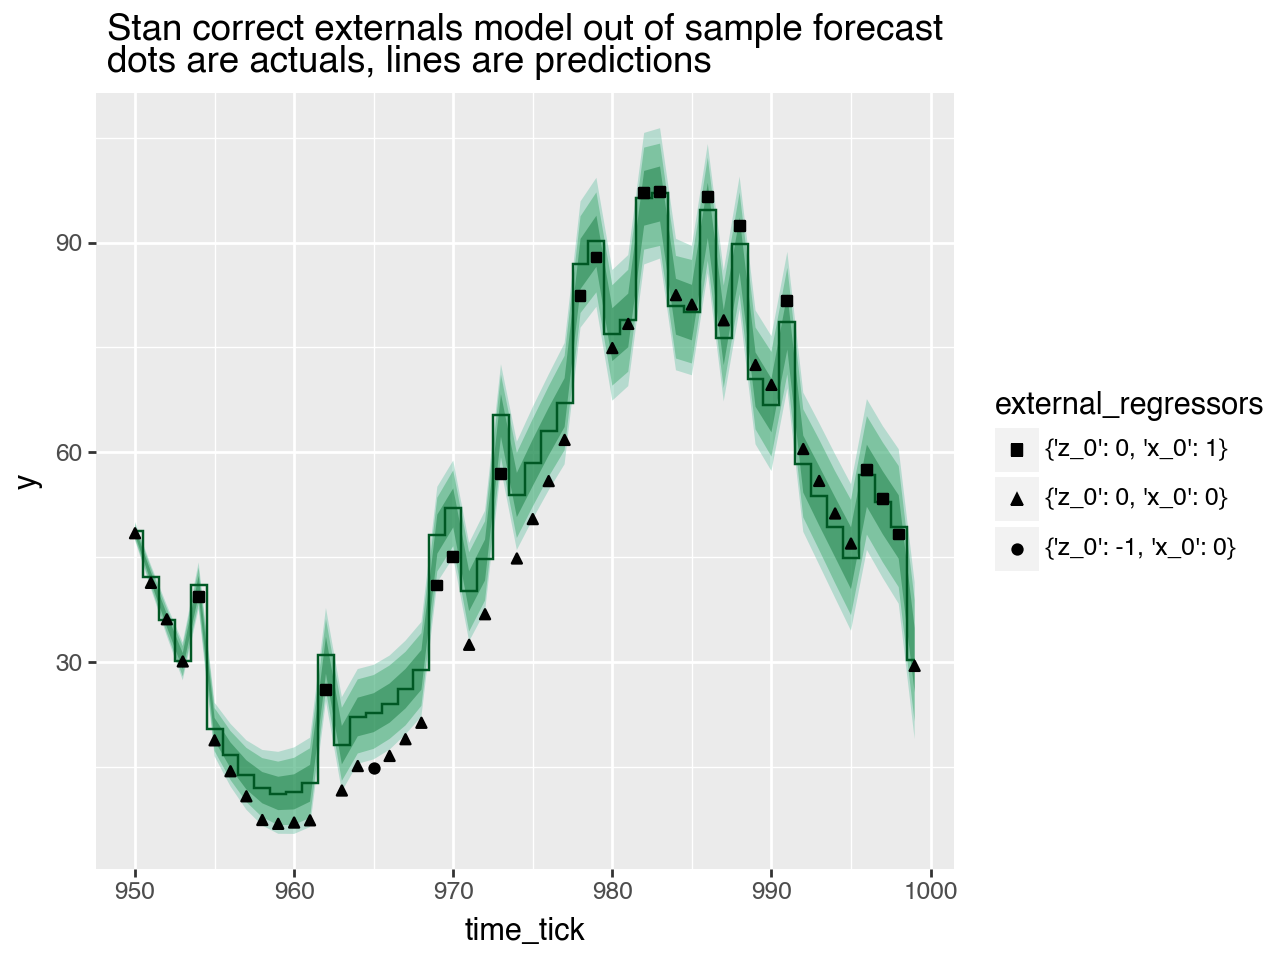

In [24]:
# plot inference over time
plt_i, s_frame_i = plot_forecast(
    forecast_soln_i, 
    d_test,
    model_name='Stan correct externals model',
    external_regressors=['z_0', 'x_0'],
)
plt_i.show()


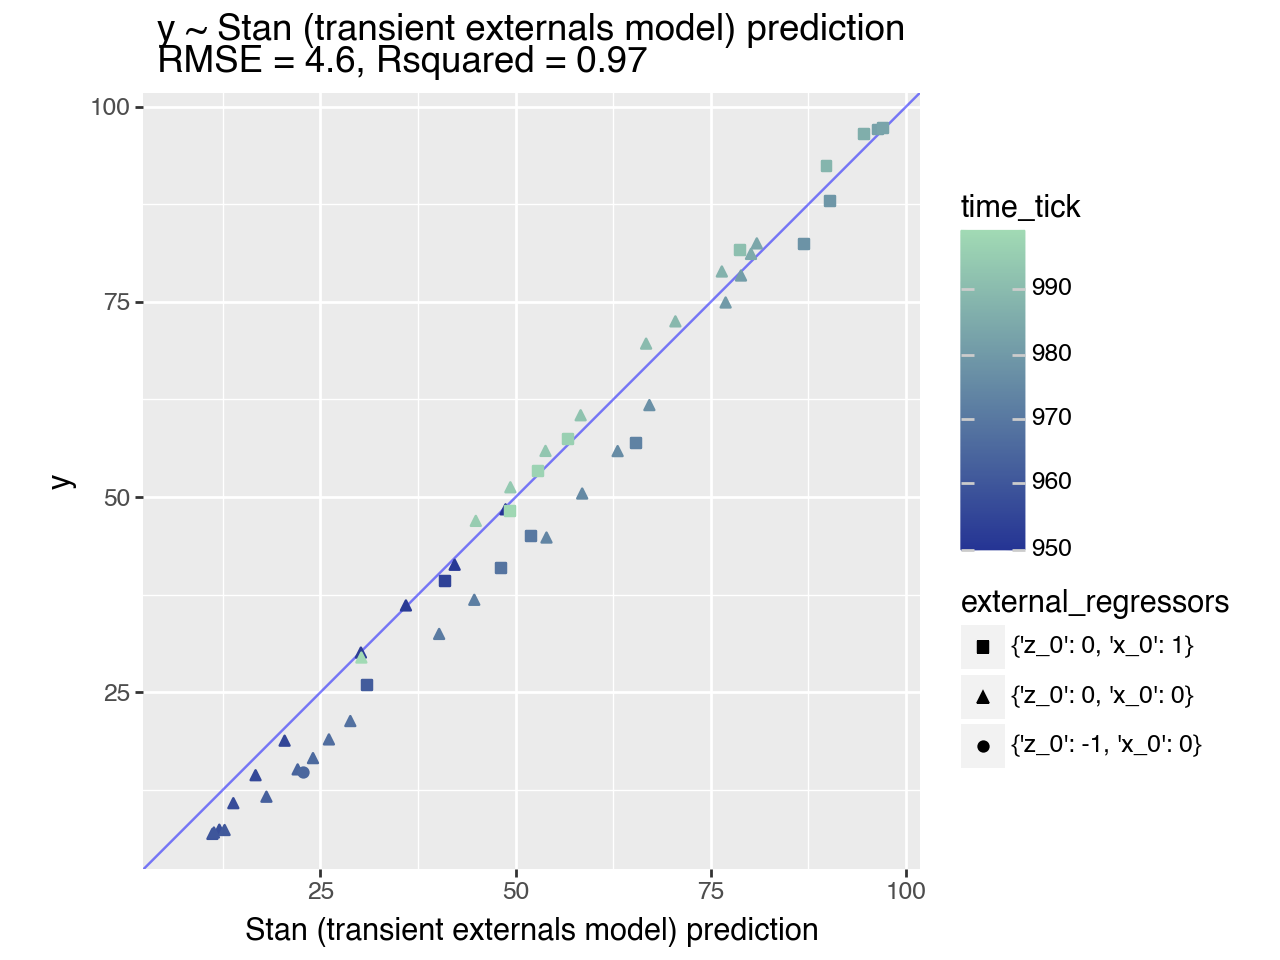

In [25]:
# plot quality of fit as a scatter plot
d_test['Stan (transient externals model) prediction'] = extract_sframe_result(s_frame_i)
plot_model_quality(
    d_test=d_test,
    result_name='Stan (transient externals model) prediction',
    external_regressors=['z_0', 'x_0'],
)


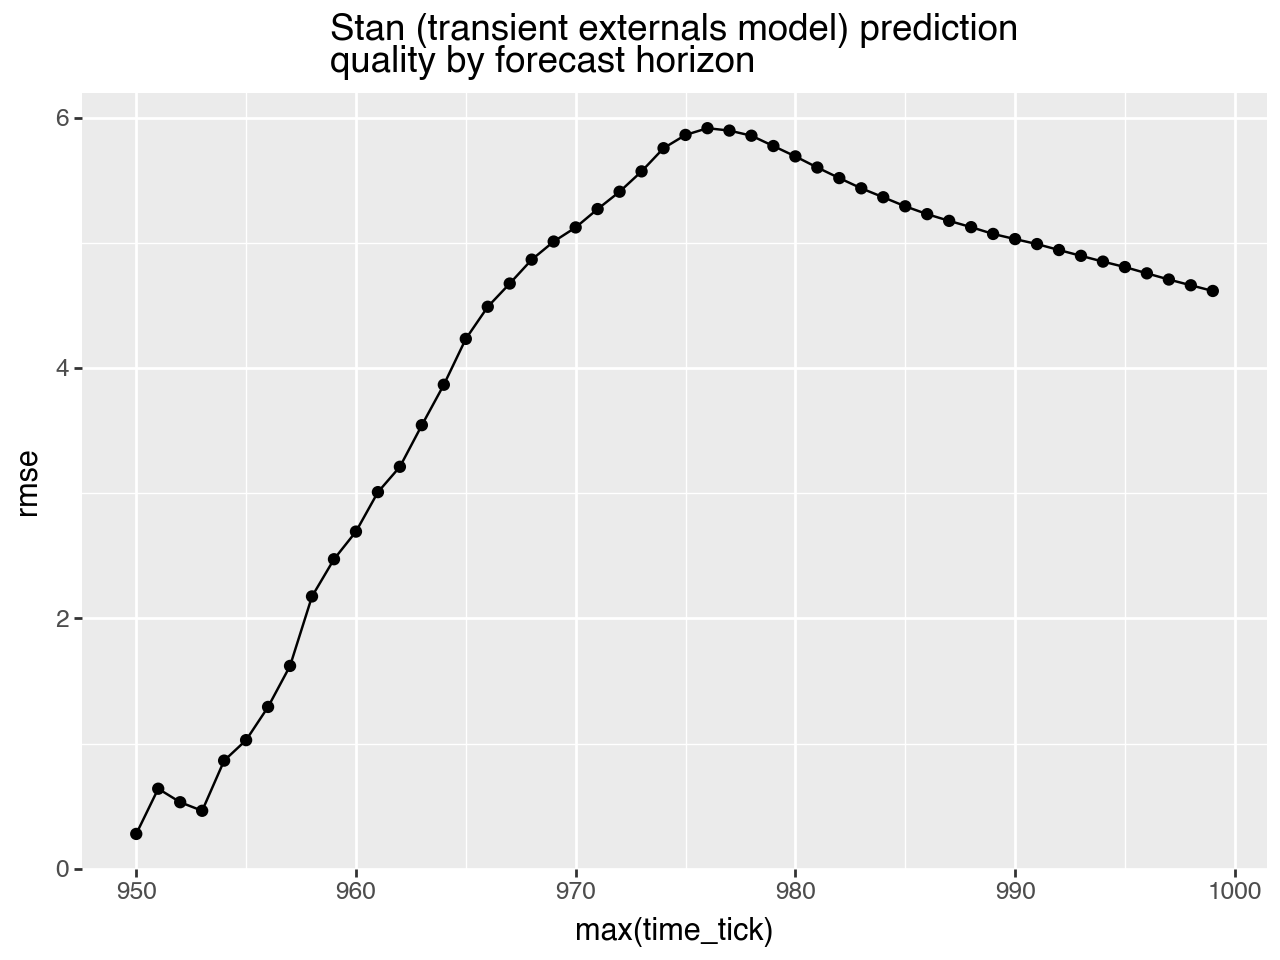

In [26]:
# plot quality as a function of how far out we are predicting
plot_model_quality_by_prefix(
    s_frame=s_frame_i,
    d_test=d_test,
    result_name='Stan (transient externals model) prediction',
)


The model identifies 3 very valuable things:

  * Estimates of the model parameters: 
     * `b_auto_0`
     * `b_auto[0]`
     * `b_auto[1]`
     * `b_x_dur[0]`
     * `b_x_imp[0]`
  * Projections or applications of the model for future `time_tick`s 950 through 999.
  * Good inferences of the most recent unobserved states `y_auto[948]` and `y_auto[949]` in the training period.

The third item provides a much more useful estimate of then hidden state (based on evaluation of trajectories through the entire training period) than the simple single point estimate `y_auto[i] ~ y[i] * b_x_impl[0] - x_0[i]`. One can evolve estimates forward from these inferences, and that is not always the case for the simple expected value estimates.

The issue with the simple (or naive) estimates being: they are single value point estimates, not necessarily compatible with *any* of the estimate sampling trajectories. Plugging in the naive estimates often does not allow one to evolve the prediction trajectories forward in a sensible manner. The detailed estimates from the Stan sampler do allow such forward evolution of estimates (either inside the Stan sampler as shown, or as a simple external procedure).


For this model the future state is determined by the model parameters plus the last hidden state estimated int the training period. The distribution of these estimates across different samples is shown here. Notice they are not the same as the simple "point expected value" estimates one might try by hand (vertical lines in the plot).

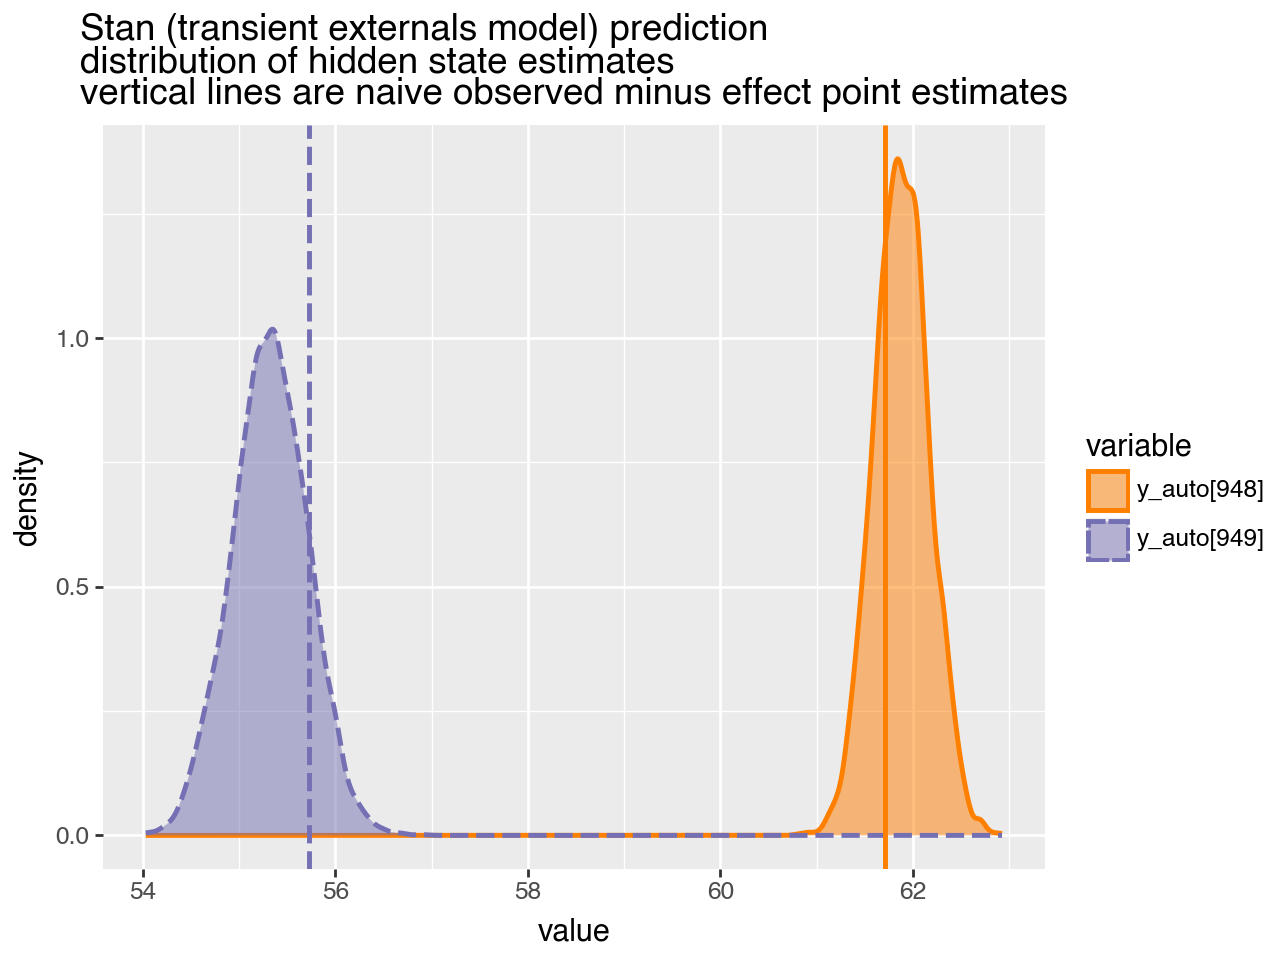

In [27]:
plot_recent_state_distribution(
    d_train=d_train,
    forecast_soln=forecast_soln_i,
    generating_lags=generating_lags,
    result_name='Stan (transient externals model) prediction',
)


## Bayesian method without external regressors


Let's get back to overall methodology.

As a lower-bound on model quality we can try a Bayesian (Stan) model without external regressors.


In [28]:
# define a Stan model without external predictors
stan_model_with_forecast_0, stan_model_with_forecast_src_0 = define_Stan_model_with_forecast_period(
    application_lags=generating_lags,
    n_transient_external_regressors=0,
    n_durable_external_regressors=0,
)


In [29]:
# show the model specification
print(stan_model_with_forecast_src_0)



data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;            // observed outcomes
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (transient) noise variance
}
transformed parameters {
        // y_observed and y_future in one notation (for subscripting)
  vector[N_y_observed + N_y_future] y;        
  y[1:N_y_observed] = y_observed;
  y[(N_y_observed + 1):(N_y_observed + N_y_future)] = y_future;
}
m

In [30]:
# sample from Stan model solutions
forecast_soln_0 = solve_forecast_by_Stan(
    model=stan_model_with_forecast_0, 
    d_train=d_train,
    d_apply=d_test,
    )


In [31]:
# summarize parameter estimates
forecast_soln_0.loc[
    :,
    [c for c in forecast_soln_0 if c.startswith('b_')]
].median()


b_auto_0        1.489060
b_auto[0]       1.332412
b_auto[1]      -0.374746
b_var_y_auto    4.986906
b_var_y         4.784605
dtype: float64

In [32]:
# show original generative parameters
generating_params


{'b_auto_0': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_z': (4.2,),
 'b_x': (16.1,)}

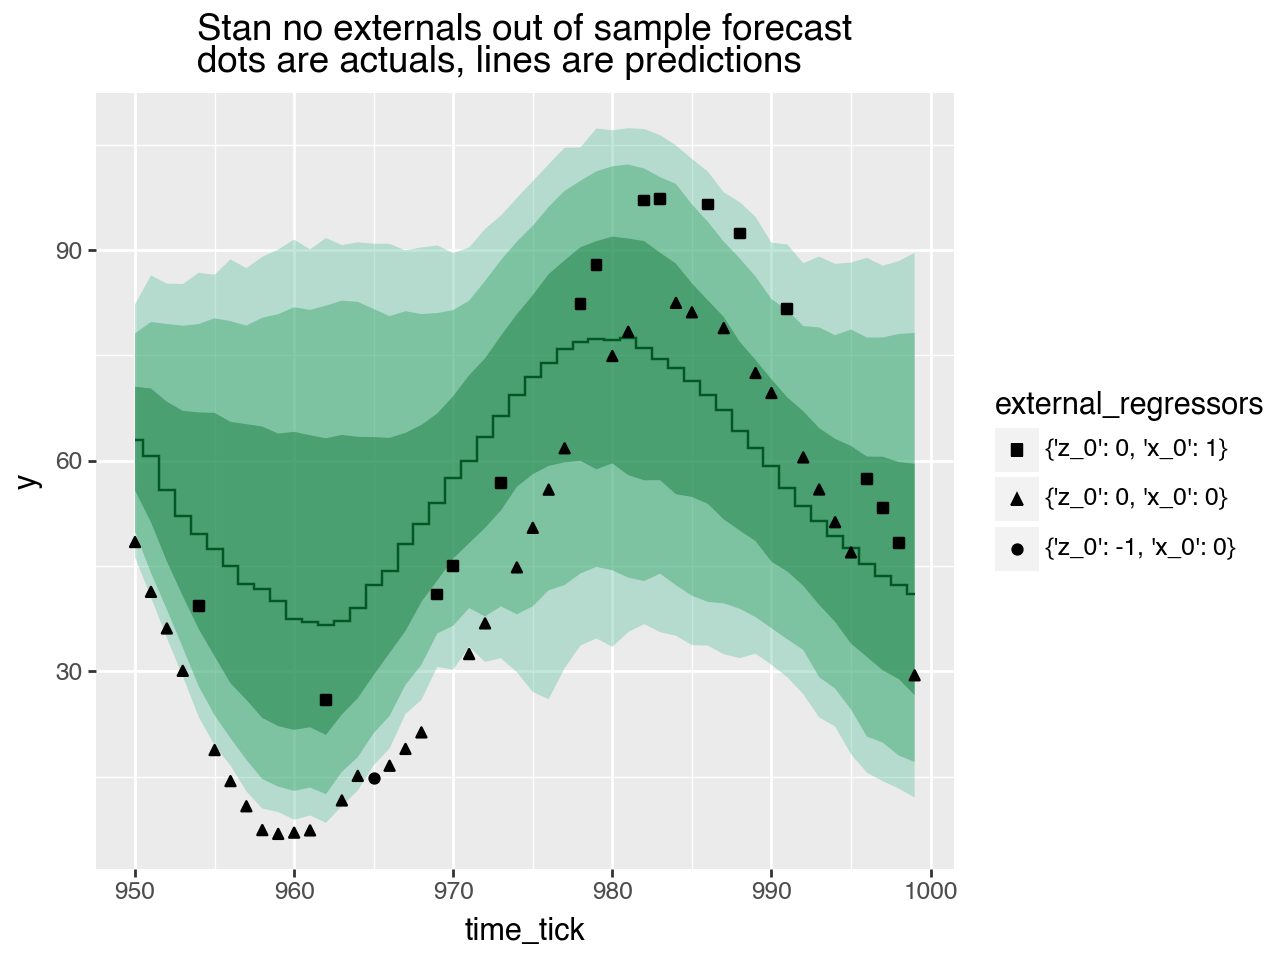

In [33]:
# plot fit over time
plt_0, s_frame_0 = plot_forecast(
    forecast_soln_0, 
    d_test,
    model_name='Stan no externals',
    external_regressors=['z_0', 'x_0'],
)
plt_0.show()


Notice both the predictions are "middle of the road" estimates again.

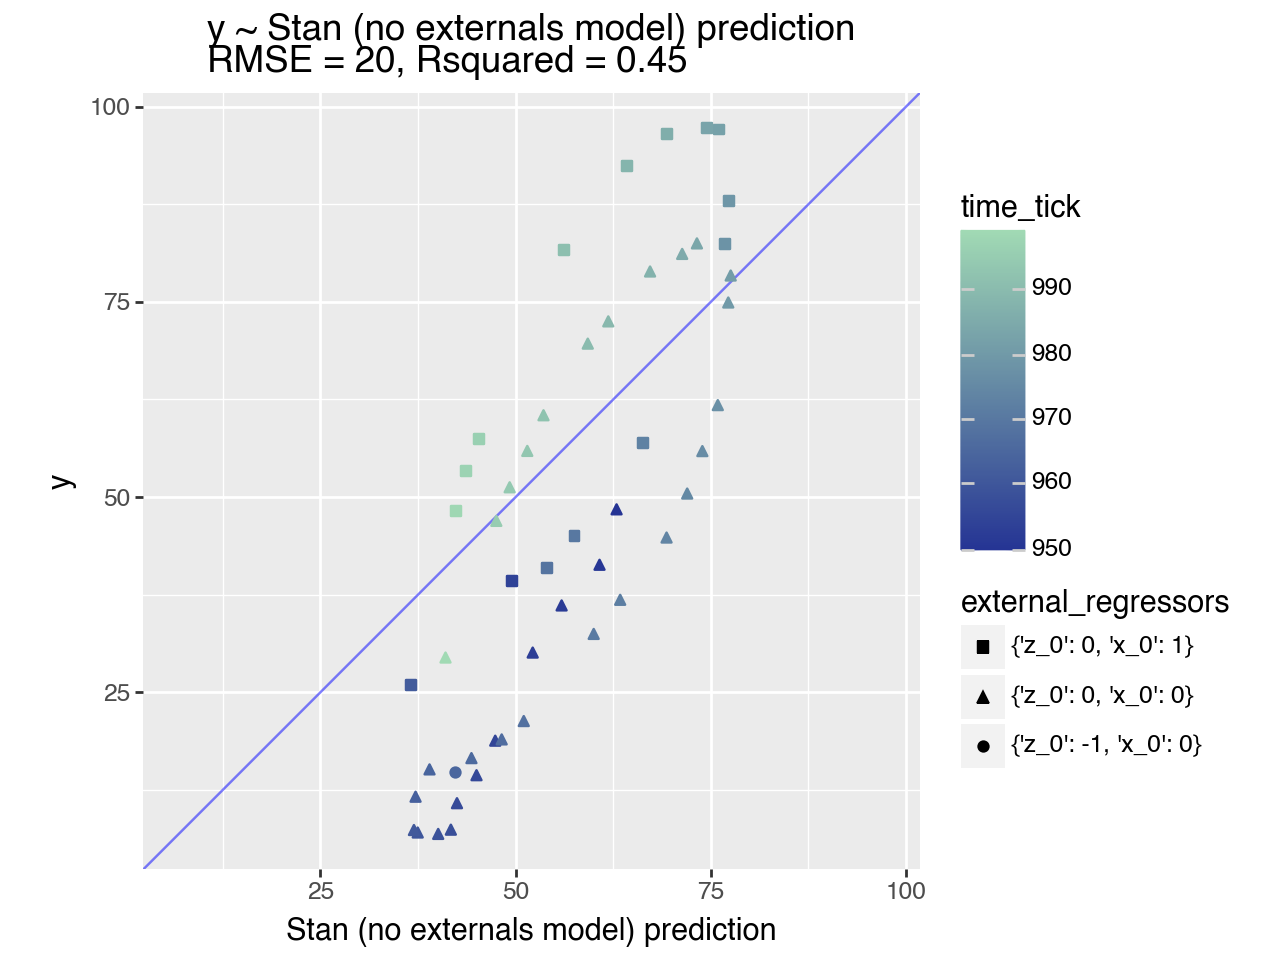

In [34]:
# plot quality of fit as a scatter plot
d_test['Stan (no externals model) prediction'] = extract_sframe_result(s_frame_0)
plot_model_quality(
    d_test=d_test,
    result_name='Stan (no externals model) prediction',
    external_regressors=['z_0', 'x_0'],
)


## R packages

Both the forecast and fable R packages [solve the regression with ARIMA residuals formulation quite well](https://github.com/WinVector/Examples/blob/main/TimeSeries/ts_example.md).

## Conclusion

And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause transient effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.